# Clean and Summarise the data

### Preparation

In [166]:
# The modules we will need

# We import the SQLite python module for the database handling
import sqlite3


# NumPy might be useful in some cases with data manipulating 
import numpy as np


# pandas will be useful for storing and processing query results
import pandas as pd

# an option for displaying all the columns of our main dataframe
pd.options.display.max_columns = 30


# With matplotlib we can do the plotting
import matplotlib.pyplot as plt
%matplotlib inline

# with the styles we can control the way plots look like.
from matplotlib import style
style.use((['ggplot',  'fast']))


# alternatively, we can also use seaborn
import seaborn as sns


# while the OS module will help us manage the filepaths
import os


In [2]:
# The database filepath.

# The current working directoary
cwd = os.getcwd()

# Note that we have created a symbolic link, placed in the input folder of phase_3, pointing to the database
database_name = 'link_to_db'
filepath_to_database = cwd + '/' + 'input' + '/' + database_name


Since we will be running a lot of queries, passing the results into dataframes, we should create some helper functions.

In [3]:

def my_queries( filepath, query ):
    '''
    input: an sqlite query - a string, and the filepath to the database - a string
    output: a dataframe - the result of the query
    '''
    
    # connect to the database
    try:
        conn = sqlite3.connect(filepath)
    except:
        print('cannot connect to database')
    cursor = conn.cursor()

    
    # run the query and get the results into a dataframe
    try:
        query_df = pd.read_sql_query(query, conn, index_col=None, coerce_float=False, parse_dates=None, chunksize=None)
    except:
        print('could not generate dataframe - maybe error in sql query?')
    
    # don't forget to close the connection 
    conn.close()

    
    # return the result
    return query_df
    

In [4]:

def nulls_percentage(filepath, table_column):
    '''
    input: the filepath to the database as a string, and the name of the column 
        for which we want to count nulls, as a string
    output: a dataframe, with one row and three columns: the number of null_values,  
        the number of not_null_values, and the percentage_of_nulls over the total
    '''
    
    query = (''' select sum(case when {0} is null then 1 else 0 end) as null_values 
    , count({0}) as not_null_values 
    , sum(case when {0} is null then 1 else 0 end) * 1.0 
    / (  select count(*) from flights ) as percentage_of_nulls from flights;'''.format(table_column))
    
    return my_queries(filepath, query)




### Now we start with the boring part: collecting facts on our dataset - we work mostly with the flights table

In [5]:
# Fact1: 7009724 observations in flights

In [6]:
# a simple count

query = '''

select count(*) as flights_count 
from flights

'''

my_queries(filepath_to_database, query)

,flights_count
0,7009724


In [7]:
# Recall the columns in the dataframe. Then we will look into them, one by one.

In [8]:
# a look in the info

query = '''

PRAGMA table_info(flights);

'''

my_queries(filepath_to_database, query)

,cid,name,type,notnull,dflt_value,pk
0,0,FlightYear,int,1,None,1
1,1,FlightMonth,int,1,None,2
2,2,FlightDay,int,1,None,3
3,3,DayOfWeek,int,0,None,0
4,4,DepTime,varchar(5),0,None,0
5,5,CRSDepTime,varchar(5),1,None,7
6,6,ArrTime,varchar(5),0,None,0
7,7,CRSArrTime,varchar(5),0,None,0
8,8,UniqueCarrier,varchar(7),1,None,4
9,9,FlightNum,int,1,None,5


### FlightMonth

In [9]:
# Looking at FlightMonth

In [10]:
# Fact2: there are no missing values for FlightMonth

In [11]:
nulls_percentage(filepath_to_database, 'FlightMonth')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [12]:
# Fact3: Relatively little variation for FlightMonth when analysed per month

In [13]:
# Total flights per month

query = '''

select FlightMonth, count(FlightMonth) as Flights_per_Month
from flights
group by FlightMonth

'''

query_df = my_queries(filepath_to_database, query)

In [14]:
# we pass the list to the dataframe and change the index from 0-11, to Jan-Dec
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct' , 'Nov', 'Dec']

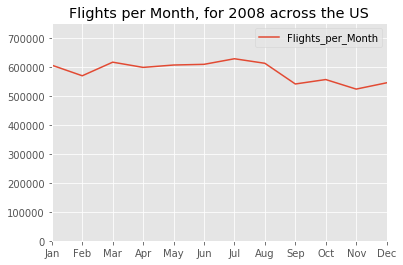

In [15]:
query_df.set_index(pd.Index(months))['Flights_per_Month'].plot(  title = 'Flights per Month, for 2008 across the US' # The title
                                                            , ylim=(0,750000)  # the range for y-axis
                                                            , xticks=np.arange(12)  # we want all months shown on x-axis
                                                            , legend=True
                                                                )  


### FlightDay

In [16]:
# Looking at FlightDay

In [17]:
# Fact4: there are no missing values for FlightDay

In [18]:
nulls_percentage(filepath_to_database, 'FlightDay')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [19]:
# Fact5: More variation for FlightDay when analysed per day. Weekly variation observable

In [20]:
# Total flights per day

query = '''

select FlightMonth, FlightDay, count(FlightDay) as Flights_per_Day
from flights
group by FlightMonth, FlightDay

'''

query_df = my_queries(filepath_to_database, query)

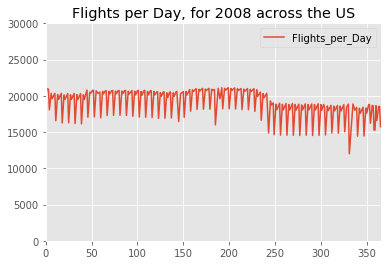

In [21]:
query_df['Flights_per_Day'].plot( title = 'Flights per Day, for 2008 across the US'
                                , ylim = (0,30000) 
                                , legend=True )

In [22]:
# Note that Flights_per_Day span the 366 days of the whole leap year

query_df['Flights_per_Day'].size

366

In [24]:
# Also note that we are in 2008, and the financial crisis is visible in the sudden drop in flights around September

In [25]:
# Inference 1: The data seems to be distributed across the year. 
# Most probably there are not, at least visibly, missing flights.

### DepTime

In [26]:
# Fact6: There are 136246 (1.9%) nulls for departure times. We need to confirm whether these are missing or not applicable

In [27]:
nulls_percentage(filepath_to_database, 'DepTime')

,null_values,not_null_values,percentage_of_nulls
0,136246,6873478,0.019437


In [28]:
# let us bring all the records where DepTime is null

query = '''
select *
from flights
where DepTime is null
limit 5
'''

my_queries(filepath_to_database, query)

,FlightYear,FlightMonth,FlightDay,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,None,2008-01-03 07:00,None,2008-01-03 08:30,WN,126,None,None,90,None,None,None,LAS,OAK,407,None,None,1,A,0,None,None,None,None,None
1,2008,1,3,4,None,2008-01-03 11:00,None,2008-01-03 12:15,WN,1146,None,None,75,None,None,None,LAX,OAK,337,None,None,1,A,0,None,None,None,None,None
2,2008,1,3,4,None,2008-01-03 09:05,None,2008-01-03 10:25,WN,469,None,None,80,None,None,None,LAX,SFO,337,None,None,1,A,0,None,None,None,None,None
3,2008,1,3,4,None,2008-01-03 16:20,None,2008-01-03 17:40,WN,618,None,None,80,None,None,None,LAX,SFO,337,None,None,1,C,0,None,None,None,None,None
4,2008,1,3,4,None,2008-01-03 19:30,None,2008-01-03 20:35,WN,2528,None,None,65,None,None,None,LAX,SJC,308,None,None,1,A,0,None,None,None,None,None


In [29]:
# We observe that all these flights were Cancelled. We brought only 5 records; is it the same for all of them?

In [30]:
# All cancelled flights. Recall that Cancelled flights are encoded as 0, 1

query = '''
select sum(Cancelled) 
from flights
'''

my_queries(filepath_to_database, query)

,sum(Cancelled)
0,137434


In [31]:
# The missing DepTime is 136246 which is the same as the Cancelled when DepTime is missing

In [32]:
# All cancelled flights, without a Departure Time.

query = '''
select sum(Cancelled)
from flights
where DepTime is null
'''

my_queries(filepath_to_database, query)

,sum(Cancelled)
0,136246


In [33]:
# Fact7: Whenever DepTime is missing, the flight has been cancelled. All the nulls are effectively 'non applicable'

In [34]:
# Fact8: The range of DepTime is within the 24 hours

In [35]:

query = '''
select max(DepTime), min(DepTime)
from flights
'''

my_queries(filepath_to_database, query)

,max(DepTime),min(DepTime)
0,2008-12-31 23:59,2008-01-01 00:1


### CRSDepTime (Planned Departure Time)

In [36]:
# Fact9 : No missing values for planned departures

In [37]:
nulls_percentage(filepath_to_database, 'CRSDepTime')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [38]:
# Fact10: The range of CRSDepTime is within the 24 hours

In [39]:

query = '''
select  max(CRSDepTime), min(CRSDepTime)
from flights
'''

my_queries(filepath_to_database, query)

,max(CRSDepTime),min(CRSDepTime)
0,2008-12-31 23:59,2008-01-01 00:10


### ArrTime

In [40]:
# Fact11: There are 151649 (2.1%) nulls for arrival times. We need to confirm whether these are missing or not applicable

In [41]:
nulls_percentage(filepath_to_database, 'ArrTime')

,null_values,not_null_values,percentage_of_nulls
0,151649,6858075,0.021634


In [42]:
# Fact12: Arr Time is null (151649) either because the flight was Cancelled, or Diverted (sum = 151649) => not applicable

In [43]:
# let us bring all the records where ArrTime is null, and sum the Diverted and Cancelled flights - both are encoded 0, 1.

query = '''
select sum(Diverted) + sum(Cancelled)
from flights
where ArrTime is null

'''

my_queries(filepath_to_database, query)

,sum(Diverted) + sum(Cancelled)
0,151649


In [44]:
# Fact13: No flight is Cancelled and Diverted at the same time

In [45]:
# Just a little check that no records exit where a flight is both Cancelled and Diverted

query = '''
select sum(Diverted) + sum(Cancelled)
from flights
where Diverted = 1 and Cancelled = 1

'''

my_queries(filepath_to_database, query)

,sum(Diverted) + sum(Cancelled)
0,None


In [46]:
# Fact14: The range of ArrTime is within the 24 hours

In [47]:

query = '''
select  max(ArrTime), min(ArrTime)
from flights
'''

my_queries(filepath_to_database, query)

,max(ArrTime),min(ArrTime)
0,2008-12-31 24:00,2008-01-01 00:1


### CRSArrTime (Planned Arrival Time)

In [48]:
# Fact15: No missing values for planned arrivals

In [49]:
nulls_percentage(filepath_to_database, 'CRSArrTime')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [50]:
# Fact16: The range of CRSArrTime is within the 24 hours

In [51]:

query = '''
select  max(CRSArrTime), min(CRSArrTime)
from flights
'''

my_queries(filepath_to_database, query)

,max(CRSArrTime),min(CRSArrTime)
0,2008-12-31 23:59,2008-01-01 00:1


### UniqueCarrier

In [52]:
# Fact17: There are no missing values for carriers

In [53]:
nulls_percentage(filepath_to_database, 'UniqueCarrier' )

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [54]:
# Fact18: There are 20 carriers in a fairly competitive market, with market shares less than 10% for 19 of them; not counting alliances...

In [55]:
# We use a simple join to get the carrier's name from the carriers table

query = '''
select 
    flights.UniqueCarrier
    , carriers.Full_name as carrier_name
    , count(flights.UniqueCarrier) as flights_count
    , count(flights.UniqueCarrier) * 1.0 / (select count(*) from flights) as market_share
from flights join carriers on (flights.UniqueCarrier = carriers.Code)
group by UniqueCarrier
order by flights_count desc
'''

query_df = my_queries(filepath_to_database, query)

In [58]:
query_df

,UniqueCarrier,carrier_name,flights_count,market_share
0,WN,Southwest Airlines Co.,1201754,0.171441
1,AA,American Airlines Inc.,604885,0.086292
2,OO,Skywest Airlines Inc.,567159,0.080910
3,MQ,American Eagle Airlines Inc.,490693,0.070002
4,US,US Airways Inc. (Merged with America West 9/05...,453589,0.064709
5,DL,Delta Air Lines Inc.,451931,0.064472
6,UA,United Air Lines Inc.,449515,0.064127
7,XE,Expressjet Airlines Inc.,374510,0.053427
8,NW,Northwest Airlines Inc.,347652,0.049596
9,CO,Continental Air Lines Inc.,298455,0.042577


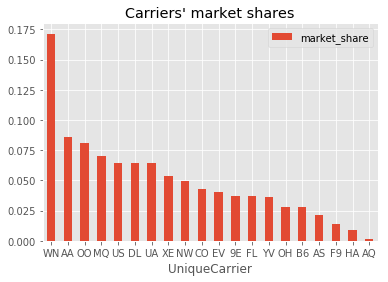

In [59]:
query_df.set_index('UniqueCarrier')[ 'market_share'].plot( kind='bar', legend=True, title="Carriers' market shares", rot=0)


### FlightNum

In [60]:
# Fact19: There are no missing values for flight numbers

In [61]:
nulls_percentage(filepath_to_database, 'FlightNum')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [62]:
# Fact20: The flight numbers range from 1 to almost 9999, which is the maximum allowed.

In [63]:

query = '''
select  max(FlightNum), min(FlightNum)
from flights

'''

query_df = my_queries(filepath_to_database, query)

In [64]:
query_df

,max(FlightNum),min(FlightNum)
0,9743,1


### TailNum

In [65]:
# We have made a mistake with the database loading. Follow along

In [66]:
# It seems thare are no missing values
nulls_percentage(filepath_to_database, 'TailNum')

,null_values,not_null_values,percentage_of_nulls
0,83365,6926359,0.011893


In [67]:
# But take a look at this detail. There are flights where TailNum is an empty string

query = '''
select count(TailNum) 
from flights
where TailNum == ''
'''

my_queries(filepath_to_database, query)

,count(TailNum)
0,0


In [68]:
# In the vast majority of cases empty TailNum is because of Cancellation

query = '''
select CancellationCode, count(*)
from flights
where TailNum = ''
group by CancellationCode
'''

my_queries(filepath_to_database, query)

,CancellationCode,count(*)


In [69]:
# Yet there are 7 flights where the TailNum should be there

query = '''
select TailNum, FlightNum, FlightMonth, Origin, Dest, FlightDay, UNiqueCarrier, ActualElapsedTime, ArrTime, Diverted
from flights
where TailNum = '' and CancellationCode is null
'''

my_queries(filepath_to_database, query)

,TailNum,FlightNum,FlightMonth,Origin,Dest,FlightDay,UniqueCarrier,ActualElapsedTime,ArrTime,Diverted


In [70]:
# Attention1: We made a mistake to load empty strings in TailNum, without transforming them into None. There are 7 missing values

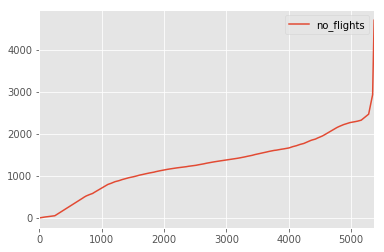

In [71]:
# Yearly number of flights per airplane

query = '''
select TailNum, count(*) as no_flights 
from flights
where TailNum != ''
group by TailNum
order by no_flights
'''

my_queries(filepath_to_database, query).plot()


### ActualElapsedTime

In [72]:
# Fact21: There are 154699 (2.2%) nulls for ActualElapsedTime times. We need to confirm whether these are missing or not applicable

In [73]:
nulls_percentage(filepath_to_database, 'ActualElapsedTime')

,null_values,not_null_values,percentage_of_nulls
0,154699,6855025,0.022069


In [74]:
# Fact22: ActualElapsedTime is null (154699) either because the flight was Cancelled, or Diverted (sum = 154699)
# Recall that no records exit where a flight is both Cancelled and Diverted

In [75]:
# let us bring all the records where ActualElapsedTime is null, and sum the Diverted and Cancelled flights - both are encoded 0, 1.

query = '''
select sum(Diverted) + sum(Cancelled)
from flights
where ActualElapsedTime is null

'''

my_queries(filepath_to_database, query)

,sum(Diverted) + sum(Cancelled)
0,154699


### CRSElapsedTime

In [76]:
# There seem to be 844 missing values; Shouldn't all flights have an estimated elapsed time?

nulls_percentage(filepath_to_database, 'CRSElapsedTime')

,null_values,not_null_values,percentage_of_nulls
0,844,7008880,0.00012


In [77]:
# All the cases are split between Cancelled and Diverted flights, and...

query = '''
select Diverted, Cancelled, count(*)
from flights
where CRSElapsedTime is null
group by Diverted, Cancelled
'''

my_queries(filepath_to_database, query)

,Diverted,Cancelled,count(*)
0,0,1,246
1,1,0,598


In [78]:
# ... interestingly enough, these flights go only up to September. 

query = '''
select FlightMonth, count(*)
from flights
where CRSElapsedTime is null
group by FlightMonth
'''

my_queries(filepath_to_database, query)

,FlightMonth,count(*)
0,1,106
1,2,87
2,3,102
3,4,112
4,5,52
5,6,88
6,7,97
7,8,103
8,9,97


In [79]:
# Fact22a: There are 844 missing values for planned elapsed time that follow a pattern.
# Split among Cancelled and Diverted, and within a certain date range - until September

In [80]:
# What about ranges?

In [81]:
query = '''
select CRSElapsedTime
from flights
where CRSElapsedTime is not null
'''

my_queries(filepath_to_database, query).describe().astype(int)

,CRSElapsedTime
count,7008880
mean,128
std,69
min,-141
25%,80
50%,110
75%,159
max,1435


In [82]:
# A planned elapsed time, close to zero???

query = '''
select CRSElapsedTime
from flights
where CRSElapsedTime < 5
'''

my_queries(filepath_to_database, query).describe().astype(int)

,CRSElapsedTime
count,70
mean,-18
std,47
min,-141
25%,1
50%,1
75%,1
max,2


In [83]:
query = '''
select *
from flights
where CRSElapsedTime < 5
'''

my_queries(filepath_to_database, query).sort_values(['CRSElapsedTime'])

,FlightYear,FlightMonth,FlightDay,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
53,2008,7,15,2,2008-07-15 13:24,2008-07-15 13:30,2008-07-15 13:58,2008-07-15 11:09,HA,344,N479HA,34.0,-141,22.0,169.0,-6.0,LIH,HNL,102,6.0,6.0,0,None,0,169.0,0.0,0.0,0.0,0.0
54,2008,7,21,1,2008-07-21 13:27,2008-07-21 13:30,2008-07-21 13:55,2008-07-21 11:09,HA,344,N480HA,28.0,-141,17.0,166.0,-3.0,LIH,HNL,102,5.0,6.0,0,None,0,166.0,0.0,0.0,0.0,0.0
55,2008,7,22,2,2008-07-22 13:27,2008-07-22 13:30,2008-07-22 13:59,2008-07-22 11:09,HA,344,N485HA,32.0,-141,21.0,170.0,-3.0,LIH,HNL,102,5.0,6.0,0,None,0,170.0,0.0,0.0,0.0,0.0
56,2008,7,28,1,2008-07-28 13:27,2008-07-28 13:30,2008-07-28 13:54,2008-07-28 11:09,HA,344,N481HA,27.0,-141,18.0,165.0,-3.0,LIH,HNL,102,4.0,5.0,0,None,0,165.0,0.0,0.0,0.0,0.0
52,2008,7,29,2,2008-07-29 13:23,2008-07-29 13:30,2008-07-29 13:56,2008-07-29 11:10,HA,165,N478HA,33.0,-140,23.0,166.0,-7.0,OGG,HNL,100,4.0,6.0,0,None,0,166.0,0.0,0.0,0.0,0.0
50,2008,7,22,2,2008-07-22 13:28,2008-07-22 13:30,2008-07-22 13:56,2008-07-22 11:10,HA,165,N477HA,28.0,-140,20.0,166.0,-2.0,OGG,HNL,100,4.0,4.0,0,None,0,166.0,0.0,0.0,0.0,0.0
51,2008,7,23,3,2008-07-23 13:22,2008-07-23 13:30,2008-07-23 13:57,2008-07-23 11:10,HA,165,N475HA,35.0,-140,21.0,167.0,-8.0,OGG,HNL,100,5.0,9.0,0,None,0,167.0,0.0,0.0,0.0,0.0
49,2008,7,17,4,2008-07-17 13:26,2008-07-17 13:30,2008-07-17 13:59,2008-07-17 11:10,HA,165,N480HA,33.0,-140,20.0,169.0,-4.0,OGG,HNL,100,5.0,8.0,0,None,0,169.0,0.0,0.0,0.0,0.0
48,2008,7,29,2,2008-07-29 13:22,2008-07-29 13:30,2008-07-29 13:57,2008-07-29 11:10,HA,164,N484HA,35.0,-140,20.0,167.0,-8.0,HNL,OGG,100,5.0,10.0,0,None,0,167.0,0.0,0.0,0.0,0.0
29,2008,4,11,5,2008-04-11 07:25,2008-04-11 07:10,None,2008-04-11 06:45,OO,2631,N496CA,NaN,-25,NaN,NaN,15.0,MKG,MKE,85,NaN,8.0,0,None,1,NaN,NaN,NaN,NaN,NaN


In [84]:
# A couple of comments: 
# at index 40, CRSDepTime = 600, CRSArrTime = 642, CRSElapseTime = -18, despite both airports being at same timezone
# at index 53-56 obviously CRSArrTime is mis-typed
# majority of rows are Diverted flights

In [85]:
# Fact22b: For CRSElapsedTime, time range visibly out of bounds with many flights even with negative flight durations

In [86]:
query = '''

select *
from flights
where UniqueCarrier == '9E' and Origin == 'PIT' and Dest == 'ATL' and FlightNum = 2029
and Cancelled == 0 and Diverted == 0
order by CRSElapsedTime desc
limit 3
'''
	
my_queries(filepath_to_database, query)

,FlightYear,FlightMonth,FlightDay,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,3,9,7,2008-03-09 18:23,2008-03-09 14:20,2008-03-09 20:51,2008-03-09 19:10,9E,2029,91469E,148,290,90,101,243,PIT,ATL,526,32,26,0,None,0,0.0,0.0,0.0,0.0,101.0
1,2008,5,1,4,2008-05-01 17:32,2008-05-01 17:20,2008-05-01 19:14,2008-05-01 19:21,9E,2029,91479E,102,121,77,-7,12,PIT,ATL,526,14,11,0,None,0,NaN,NaN,NaN,NaN,NaN
2,2008,5,2,5,2008-05-02 17:44,2008-05-02 17:20,2008-05-02 20:00,2008-05-02 19:21,9E,2029,91619E,136,121,77,39,24,PIT,ATL,526,14,45,0,None,0,0.0,0.0,15.0,0.0,24.0


In [87]:
# This is another example. The planned time suddenly more than doubles, whithout apparent motivation.

In [88]:
# We will revisit CRSElapsedTime, after having looked at other columns too.

### AirTime

In [89]:
# This is the time an aircraft stays in the air

In [90]:
# What about NULLS? AirTime is missing for the Cancelled and Diverted flights(look directly below), as expected

nulls_percentage(filepath_to_database, 'AirTime')

,null_values,not_null_values,percentage_of_nulls
0,154699,6855025,0.022069


In [91]:
# What about the ranges?

query = '''
select AirTime
from flights
where AirTime is not null
'''

my_queries(filepath_to_database, query).describe().astype(int)

,AirTime
count,6855025
mean,104
std,67
min,0
25%,55
50%,86
75%,132
max,1350


In [92]:
# Well, Houston we have a problem. No flight could have 0 , or 1350 minutes - almost 24 hours - in the air.
# Let us see some examples, trying to find out where the problems come from.

In [93]:
query = '''

select *
from flights
where UniqueCarrier == 'HA' and Origin == 'SEA' and Dest == 'HNL' 
and Cancelled == 0 and Diverted == 0
order by AirTime desc
limit 10
'''
	
my_queries(filepath_to_database, query)

,FlightYear,FlightMonth,FlightDay,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,5,24,6,2008-05-24 09:20,2008-05-24 09:20,2008-05-24 05:19,2008-05-24 12:05,HA,21,N580HA,1379,345,1350,1034,0,SEA,HNL,2677,16,13,0,None,0,1034,0,0,0,0
1,2008,9,9,2,2008-09-09 14:11,2008-09-09 09:20,2008-09-09 05:45,2008-09-09 12:15,HA,21,N586HA,1114,355,1091,1050,291,SEA,HNL,2677,5,18,0,None,0,1040,0,0,0,10
2,2008,9,29,1,2008-09-29 09:20,2008-09-29 09:20,2008-09-29 19:12,2008-09-29 12:15,HA,21,N586HA,772,355,753,417,0,SEA,HNL,2677,6,13,0,None,0,417,0,0,0,0
3,2008,3,16,7,2008-03-16 08:04,2008-03-16 08:05,2008-03-16 13:07,2008-03-16 11:10,HA,27,N594HA,483,365,433,117,-1,SEA,HNL,2677,6,44,0,None,0,117,0,0,0,0
4,2008,4,13,7,2008-04-13 09:17,2008-04-13 09:20,2008-04-13 13:08,2008-04-13 12:25,HA,21,N582HA,411,365,387,43,-3,SEA,HNL,2677,3,21,0,None,0,43,0,0,0,0
5,2008,1,14,1,2008-01-14 09:10,2008-01-14 09:20,2008-01-14 13:47,2008-01-14 13:30,HA,21,N596HA,397,370,378,17,-10,SEA,HNL,2677,5,14,0,None,0,17,0,0,0,0
6,2008,11,21,5,2008-11-21 08:04,2008-11-21 08:05,2008-11-21 12:46,2008-11-21 12:15,HA,27,N598HA,402,370,378,31,-1,SEA,HNL,2677,10,14,0,None,0,31,0,0,0,0
7,2008,11,21,5,2008-11-21 09:12,2008-11-21 09:20,2008-11-21 13:59,2008-11-21 13:30,HA,21,N589HA,407,370,376,29,-8,SEA,HNL,2677,8,23,0,None,0,29,0,0,0,0
8,2008,3,12,3,2008-03-12 09:17,2008-03-12 09:20,2008-03-12 12:58,2008-03-12 12:25,HA,21,N580HA,401,365,375,33,-3,SEA,HNL,2677,12,14,0,None,0,33,0,0,0,0
9,2008,1,12,6,2008-01-12 09:15,2008-01-12 09:20,2008-01-12 13:46,2008-01-12 13:30,HA,21,N593HA,391,370,372,16,-5,SEA,HNL,2677,4,15,0,None,0,16,0,0,0,0


In [95]:
# It is obvious that the plane could have stayed for more than 22 hours in the air.
# One possible explanation is that if the plane had indeed departed, then it made a stop midway, before finaly arriving.

### Cancelled and Diverted

In [96]:
# Since cancelled and diverted flights show up in our calculations, we should next turn to these

In [97]:
# Fact23: There are no missing values for either Cancelled, or Diverted

In [98]:
nulls_percentage(filepath_to_database, 'Cancelled')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [99]:
nulls_percentage(filepath_to_database, 'Diverted')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [100]:
# Fact24: There are 17265 diverted and 137434 cancelled flights. Both take values 0 and 1.

In [101]:
# Looking at cancelled and diverted

query = '''
select Cancelled, Diverted,  count(*)
from flights
group by Cancelled, Diverted

'''

my_queries(filepath_to_database, query)

,Cancelled,Diverted,count(*)
0,0,0,6855025
1,0,1,17265
2,1,0,137434


### Revisiting Actual Elapsed Time and Arrival Time

In [102]:
# Looking at cancelled, diverted, elapsed, and arrival. We return a summary table for all of them

query = '''
select 
    Cancelled
    , Diverted
    , (case when ActualElapsedTime is null then 0 else 1 end) as ActElTime
    , (case when ArrTime is null then 0 else 1 end) as ArvlTme
    , count(*)
    
from flights
group by Cancelled, Diverted, ActElTime, ArvlTme


'''

my_queries(filepath_to_database, query)

,Cancelled,Diverted,ActElTime,ArvlTme,count(*)
0,0,0,1,1,6855025
1,0,1,0,0,14215
2,0,1,0,1,3050
3,1,0,0,0,137434


In [103]:
# There is a group of 3050 flights that stand out. They are Diverted but have an Arrival Time, whilst the rest do not...

In [104]:
# After some looking around we decide to group by month the diverted flights with no arrival time and...

query = '''
select FlightMonth, count(*) as no_Diverted_Flights, Count(taxiIn), count(TaxiOut)
from flights
where Diverted == 1 and ArrTime is null 
group by FlightMonth
'''
my_queries(filepath_to_database, query)

,FlightMonth,no_Diverted_Flights,Count(taxiIn),count(TaxiOut)
0,1,1327,0,1327
1,2,1715,0,1715
2,3,1564,0,1564
3,4,1048,0,1048
4,5,854,0,854
5,6,2276,0,2276
6,7,1910,0,1910
7,8,1694,0,1694
8,9,719,0,719
9,10,117,0,117


In [105]:
# ... contrast that with the diverted flights that do have an arrival time

query = '''
select FlightMonth, count(*), Count(taxiIn), count(TaxiOut)
from flights
where Diverted == 1 and ArrTime is not null 
group by FlightMonth
'''

my_queries(filepath_to_database, query)

,FlightMonth,count(*),Count(taxiIn),count(TaxiOut)
0,10,768,768,768
1,11,653,653,653
2,12,1629,1629,1629


In [106]:
# Fact25: There is a group of 3050 flights that stand out for, at least, two reasons. 
# They have a TaxiIn time, and are concentrated in only three consecutive months 

### ArrDelay

In [107]:
# Looking at nulls for arrival delays
nulls_percentage(filepath_to_database, 'ArrDelay')

,null_values,not_null_values,percentage_of_nulls
0,154699,6855025,0.022069


In [108]:
# Looking at arrival delays, against cancelled - diverted

query = '''
select Cancelled, Diverted,  count(ArrDelay)
from flights
group by Cancelled, Diverted

'''

my_queries(filepath_to_database, query)

,Cancelled,Diverted,count(ArrDelay)
0,0,0,6855025
1,0,1,0
2,1,0,0


In [109]:
# Fact26: An arrival delay is being reported if and only if the flight is neither Cancelled or Diverted (154699 flights)

In [110]:
# We will revisit ArrDelay, once we have seen the specific delays

### DepDelay

In [111]:
nulls_percentage(filepath_to_database, 'DepDelay')

,null_values,not_null_values,percentage_of_nulls
0,136246,6873478,0.019437


In [112]:
# Looking at departure delays, against cancelled - diverted

query = '''
select 
    Cancelled
    , Diverted
    , (case when DepDelay is null then 0 else 1 end) as DpDl
    , count(*)
from flights
group by Cancelled, Diverted, DpDl

'''

my_queries(filepath_to_database, query)

,Cancelled,Diverted,DpDl,count(*)
0,0,0,1,6855025
1,0,1,1,17265
2,1,0,0,136246
3,1,0,1,1188


In [113]:
# Again there is small group of 1188 flights that stand out: cancelled flights with departure delay

In [114]:
# After some looking around we decide to group by month the cancelled flights with no departure delay and...

query = '''
select FlightMonth, count(*) as no_Cancelled_Flights, count(DepDelay)
from flights
where Cancelled == 1 and Diverted == 0 and (case when DepDelay is null then 0 else 1 end) == 0
group by FlightMonth
'''
my_queries(filepath_to_database, query)

,FlightMonth,no_Cancelled_Flights,count(DepDelay)
0,1,17308,0
1,2,20596,0
2,3,16183,0
3,4,10355,0
4,5,6229,0
5,6,10931,0
6,7,10598,0
7,8,9835,0
8,9,9913,0
9,10,3059,0


In [115]:
# ... contrast that with the Cancelled flights that do have a departure delay

query = '''
select FlightMonth, count(*) as no_Cancelled_Flights, count(DepDelay)
from flights
where Cancelled == 1 and Diverted == 0 and (case when DepDelay is null then 0 else 1 end) == 1
group by FlightMonth
'''
my_queries(filepath_to_database, query)

,FlightMonth,no_Cancelled_Flights,count(DepDelay)
0,10,190,190
1,11,251,251
2,12,747,747


In [116]:
# Fact27: There is a group of 1188 flights that, as before stand out for, at least, two reasons. 
# They have a departure delay although cancelled, and are concentrated in only three consecutive months, exactly as before

### Origin and Destination

In [117]:
# No missing values for origin and destination airports

In [118]:
nulls_percentage(filepath_to_database, 'Origin')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [119]:
nulls_percentage(filepath_to_database, 'Dest')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [120]:
# The number of flights departing from each airport (in the flights table)
query = '''
select Origin, count(*) as flights_from_origin
from flights
group by Origin
order by flights_from_origin
'''
query_df = my_queries(filepath_to_database, query)



# The number of flights arriving at each airport (in the flights table)
query2 = '''
select Dest, count(*) as Flights_to_destination
from flights
group by Dest
order by Flights_to_destination
'''
query_df2 = my_queries(filepath_to_database, query2)

# We use the IATA airport code as index for the dataframes, so then we can join the two into one
query_df.set_index('Origin', inplace=True)
query_df2.set_index('Dest', inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ec4d7c860>,
      dtype=object)

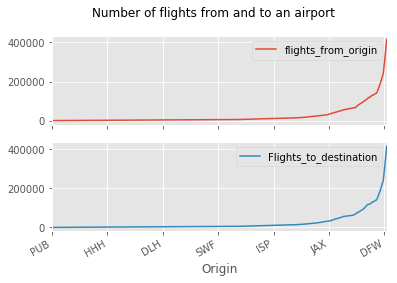

In [121]:
# Join the number of flights, outbound and inbound, for each airport, then plot them
query_df.join(query_df2).plot(subplots=True, sharex=True, title = 'Number of flights from and to an airport' )

In [122]:
# Fact28: A handfull of airports have the vast majority of the flights flown from and into them

In [123]:
# What about specific pairs of aiports? 
query = '''
select Origin, Dest, count(*) as direct_connections
from flights
group by Origin, Dest
order by direct_connections
'''

query_df = my_queries(filepath_to_database, query)

In [124]:
query_df

,Origin,Dest,direct_connections
0,ABE,BHM,1
1,ACV,SJC,1
2,ACY,JFK,1
3,ALB,BOS,1
4,ALB,SBN,1
5,AMA,TUL,1
6,ASE,GJT,1
7,ASE,MSN,1
8,ASE,RFD,1
9,ATW,CHS,1


Text(0, 0.5, 'amount of flights')

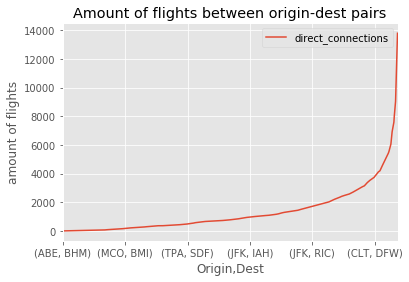

In [125]:
query_df.set_index(['Origin', 'Dest']).plot(kind='line', legend=True, title='Amount of flights between origin-dest pairs' ).set_ylabel("amount of flights")

In [126]:
# Fact29: There are 5365 different direct routes. Again, a handful of routes attract the majority of flights

### Distance

In [127]:
# No missing values for Distance
nulls_percentage(filepath_to_database, 'Distance')

,null_values,not_null_values,percentage_of_nulls
0,0,7009724,0.0


In [128]:
# What is the distance between specific pairs of aiports? 

query = '''
select Origin, Dest, Distance
from flights

'''

query_df = my_queries(filepath_to_database, query)

In [129]:
# Are the distances meaningful?

# The query returns a dataframe with Origin, Dest, and Distince
# We group by Origin and Distance. Each group holds an array of distance entries, for this pair of airports
# For each group's array, we calculate the difference between the max and min distance. Each group, gets an integer.
# In the end, we sum all the entries, one for each pair of airports.
# Zero, means that for all groups, all the distances were the same. 
# That is, for each pair of airports, the distance is always the same.

query_df.groupby(['Origin', 'Dest']).apply(lambda x: x.max() - x.min()).sum()

Distance    0
dtype: int64

In [130]:
# Fact30: There are no missing values for Distance, while the entries are consistent

### Taxiing

In [131]:
nulls_percentage(filepath_to_database, 'TaxiIn')

,null_values,not_null_values,percentage_of_nulls
0,151649,6858075,0.021634


In [132]:
nulls_percentage(filepath_to_database, 'TaxiOut')

,null_values,not_null_values,percentage_of_nulls
0,137058,6872666,0.019553


In [133]:
query = '''
select TaxiIn, TaxiOut
from flights
'''
query_df = my_queries(filepath_to_database,query)

In [140]:
# Fact31: Poisson-like distribution for both, with longer tail for TaxiOut, shorter for TaxiIn. 

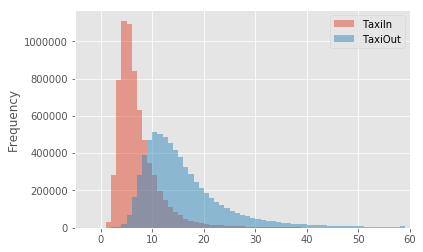

In [135]:
query_df[(query_df['TaxiOut'] < 60) & (query_df['TaxiIn'] < 60)].plot(kind='hist', bins=59, xlim=(-5, 60), alpha=0.5)

In [136]:
# Looking at taxiing, against cancelled - diverted

query = '''
select 
    Cancelled
    , Diverted
    , (case when TaxiIn is null then 0 else 1 end) as Taxi_In
    , (case when TaxiOut is null then 0 else 1 end) as Taxi_Out
    , count(*)
from flights
group by Cancelled, Diverted

'''

my_queries(filepath_to_database, query)

,Cancelled,Diverted,Taxi_In,Taxi_Out,count(*)
0,0,0,1,1,6855025
1,0,1,0,1,17265
2,1,0,0,0,137434


In [137]:
# Fact32: No TaxiIn for Cancelled and Diverted. No TaxiOut for Cancelled

### CancellationCode

In [138]:
query = '''
select Cancelled, CancellationCode, count(*)
from flights
group by CancellationCode, Cancelled
'''

my_queries(filepath_to_database, query)

,Cancelled,CancellationCode,count(*)
0,0,None,6872290
1,1,A,54330
2,1,B,54904
3,1,C,28188
4,1,D,12


In [139]:
# Fact33: The distribution of Cancellation across the categories

### Delays

In [141]:
# Recall that we had encoded delays in the following way: If no delay => all NULL, if at least one delay => all integer 

In [142]:
nulls_percentage(filepath_to_database,'NASDelay')

,null_values,not_null_values,percentage_of_nulls
0,5484991,1524733,0.782483


In [143]:
query = '''
select  count(*)as count_no_delays
--CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay
from flights
where 
    CarrierDelay is null
        or
    WeatherDelay is null 
        or
    NASDelay is null
        or
    SecurityDelay is null
        or
    LateAircraftDelay is null
'''

my_queries(filepath_to_database, query)

,count_no_delays
0,5484991


In [144]:
query = '''
select count(*) as count_delay
--CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay
from flights
where 
    CarrierDelay not null
        and
    WeatherDelay not null
        and
    NASDelay not null
        and
    SecurityDelay not null
        and
    LateAircraftDelay not null
'''


my_queries(filepath_to_database, query)

,count_delay
0,1524733


In [145]:
# We are sure we correctly loaded the delay data, and they are as expected.

# Note that no_delay + some_delay = total_flights
5484991 + 1524733 == 7009724


True

In [146]:
# Fact34: 21.8% of fligts experience some delay

In [147]:
# get all the recodrs with delays

query = '''
select  CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay
from flights
where 
    CarrierDelay is not null
'''

query_df = my_queries(filepath_to_database, query)


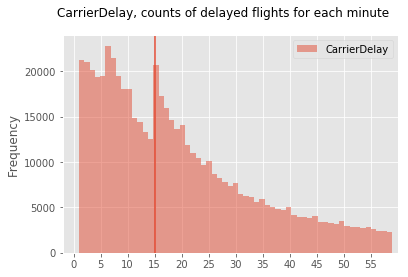

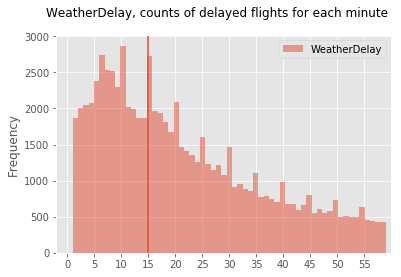

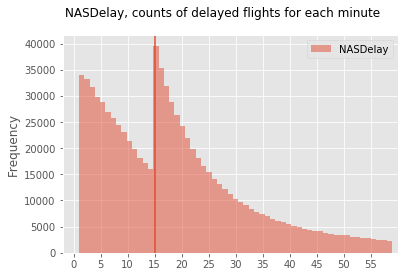

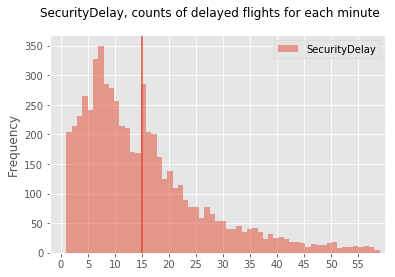

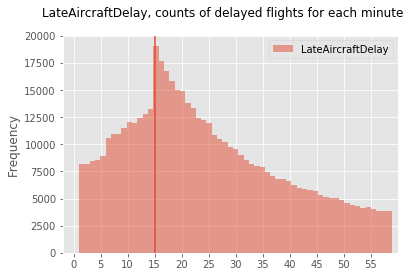

In [148]:
# A note on the delay histograms. We limit the x values to a range suitable for visual inspection, 
# and adjust the bins so that there is exactly one bin for every minute. 
# In this way every bin is the count of occurances for a certain minute, and all plots are comparable.


for delay_type in ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']:

    #plt.figure()
    query_df[(query_df[delay_type] > 0) &  (query_df[delay_type] < 60)][delay_type].plot(kind='hist'
                                                              , bins=59
                                                              , legend = True
                                                              , xlim=(-2, 60)
                                                              , sharey=False
                                                              , alpha=0.5
                                                              , subplots=True
                                                              , xticks=np.arange(0, 60, 5)
                                                              , title = "{}, counts of delayed flights for each minute ".format(delay_type)
                                                             )
    plt.axvline(15)
    plt.show()

In [149]:
# what about the sum of delays?

query = '''
select  CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay as delay_sum
from flights
where 
    CarrierDelay is not null
'''

query_df = my_queries(filepath_to_database, query)


In [151]:
query_df.head()

,delay_sum
0,34
1,57
2,80
3,15
4,16


In [152]:
# Fact35a: The total delay looks like following a power law distribution
# Individual delay causes follow similar pattern, but with important peculiarities...

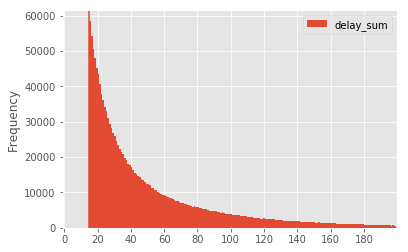

In [153]:
data = query_df[query_df['delay_sum'] < 200]

data.plot(kind='hist', bins=185, xlim=(-1,200), xticks=np.arange(0, 200, 20))
plt.axvline(15)


In [156]:
# Yet delays are only reported when they are over 15 minutes. What about the rest of the flights?

In [157]:
query = '''
select ArrDelay
from flights
'''

query_df = my_queries(filepath_to_database, query)

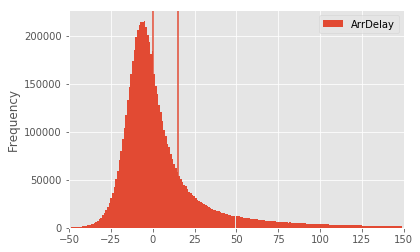

In [158]:
data = query_df[(query_df['ArrDelay'] > -50) & (query_df['ArrDelay'] < 150)]

data.plot(kind='hist', bins=200, xlim=(-50,150))
plt.axvline(15)
plt.axvline(0)

In [159]:
# Fact35b: ... but when we plot all the delays, and not only the reported ones, the picture is different

In [160]:
# Note that ArrDelay equals the sum of all delays, whenever these are over 15 minutes and do get reported

In [161]:
# Let us look at some statistics on ArrDelays

In [162]:
# We encode delays as 1 for positive delay, and 0 otherwise. We need that to do simple counting of occurences

query = '''
select 
    case when CarrierDelay ==0 then 0 else 1 end as Carrier_Delay

    , case when WeatherDelay ==0 then 0 else 1 end as Weather_Delay
    
    , case when NASDelay ==0 then 0 else 1 end as NAS_Delay
    
    , case when SecurityDelay ==0 then 0 else 1 end as Security_Delay
    
    , case when LateAircraftDelay ==0 then 0 else 1 end as LateAircraft_Delay
    
    
    
from flights
where 
    CarrierDelay is not null
'''


query_df = my_queries(filepath_to_database, query)

In [164]:
query_df.head()

,Carrier_Delay,Weather_Delay,NAS_Delay,Security_Delay,LateAircraft_Delay
0,1,0,0,0,1
1,1,0,0,0,1
2,1,0,0,0,1
3,1,0,0,0,1
4,0,0,0,0,1


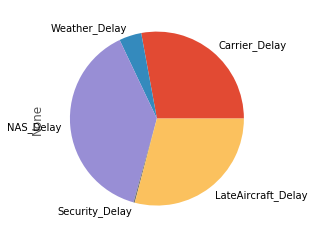

In [167]:
# The shares of each type of delay in count: How many times each type was involved in a delay
query_df.sum().plot(kind='pie')

In [168]:
# Fact37: NAS, LateAircraft and Carrier, amount for the majority of delay occurences

In [169]:
# We focus on the three major delay types, otherwise the multi-way table would be hard to read

pd.crosstab([query_df.Carrier_Delay, query_df.LateAircraft_Delay],
            [query_df.NAS_Delay ], normalize=True)

NAS_Delay                                0         1
Carrier_Delay LateAircraft_Delay                    
0             0                   0.015134  0.260471
              1                   0.136823  0.147745
1             0                   0.138185  0.127495
              1                   0.101208  0.072940

In [170]:
query = '''
select CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay
from flights
where 
    CarrierDelay not null
'''


query_df = my_queries(filepath_to_database, query)

In [172]:
query_df.head()

,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2,0,0,0,32
1,10,0,0,0,47
2,8,0,0,0,72
3,3,0,0,0,12
4,0,0,0,0,16


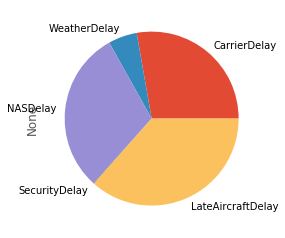

In [173]:
# The shares of each type of delay in minute: How many minutes each type has contributed to delays

query_df.sum().plot(kind='pie')

### Revisiting CRSElapsedTime

In [176]:
# We had seen that diverted and cancelled flights tended to have weird CRSElapsedTimes

In [177]:
# As we did before we will group by Carrier, Origin and Destination, and for each group we compute certain statistics
# The aim is to see how the planned flight duration changes within the year, for every airline for every route.

# We first 

query = '''
select 
    UniqueCarrier
    , Origin
    , Dest
    , count(*)
    , (max(CRSElapsedTime) - min(CRSElapsedTime)) as planned_dif
    , min(CRSElapsedTime) as min_plan
    , CRSElapsedTime as random_plan
    , avg(CRSElapsedTime) as avg_plan
    , max(CRSElapsedTime) as max_plan
    , avg(ActualElapsedTime) as avg_actual
from flights

where Diverted == 0 and Cancelled == 0
group by UniqueCarrier, Origin, Dest
order by planned_dif
'''
query_df = my_queries(filepath_to_database, query)

In [178]:
# Each row in the df represents all the flights of a carrier over a given origin-dest pair. 
# What we record for each group is a series of statistics that might help us estimate if what we see is normal
# Observe for example indexes 8526-8. We meet again the HA flights that had CRSElapsedTime mistakenly encoded


query_df.head()

,UniqueCarrier,Origin,Dest,count(*),planned_dif,min_plan,random_plan,avg_plan,max_plan,avg_actual
0,9E,ATL,BWI,71,0,109,109,109.0,109,109.408451
1,9E,ATL,CAE,1,0,58,58,58.0,58,52.000000
2,9E,ATL,DFW,1,0,154,154,154.0,154,141.000000
3,9E,ATL,EWR,28,0,140,140,140.0,140,141.428571
4,9E,ATL,MSY,1,0,96,96,96.0,96,95.000000


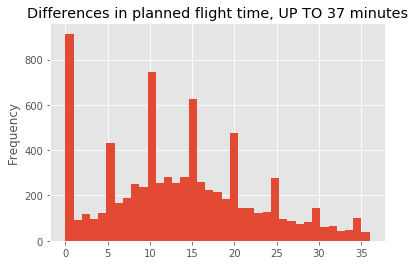

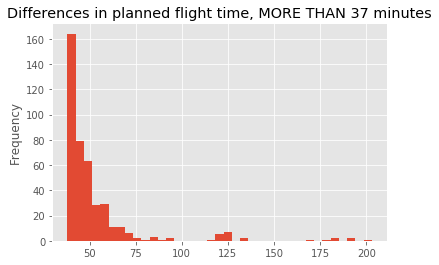

In [179]:
# We plot the 95th percentile of planned_dif (difference in duration of a flight for each distinct route of each airline) 
percent95 = int(query_df['planned_dif'].quantile(0.95))  # we need to cast it as integer, in order to feed it below

query_df[ (query_df['planned_dif'] < percent95) ]['planned_dif'].plot(kind='hist', bins=percent95)
plt.title('Differences in planned flight time, UP TO {} minutes'.format(percent95))
plt.show()

query_df[ (query_df['planned_dif'] > percent95) ]['planned_dif'].plot(kind='hist', bins=percent95)
plt.title('Differences in planned flight time, MORE THAN {} minutes'.format(percent95))
plt.show()


In [180]:
# Fact 38: For the majority of flights over a route for the same carrier, the observed differences in planned flight time seem normal.
# Yet, there is an amount of flights, some of which we have seen earlier, that do not seem normal.

In [181]:
# Let us run the above exercise for the Cancelled and Diverted flights.
# There shouldn't be a difference, since CRSElapsedTime is not related to a flight being Diverted or Cancelled.

In [182]:
# As we did before we will group by Carrier, Origin and Destination, and for each group we compute certain statistics
# The aim is to see how the planned flight duration changes within the year, for every airline for every route.

query = '''
select 
    UniqueCarrier
    , Origin
    , Dest
    , count(*)
    , (max(CRSElapsedTime) - min(CRSElapsedTime)) as planned_dif
    , min(CRSElapsedTime) as min_plan
    , CRSElapsedTime as random_plan
    , avg(CRSElapsedTime) as avg_plan
    , max(CRSElapsedTime) as max_plan
    , avg(ActualElapsedTime) as avg_actual
from flights

where Diverted == 1 or Cancelled == 1
group by UniqueCarrier, Origin, Dest
order by planned_dif
'''
query_df = my_queries(filepath_to_database, query)

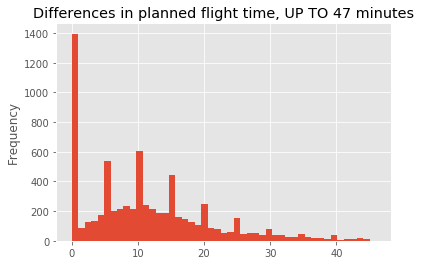

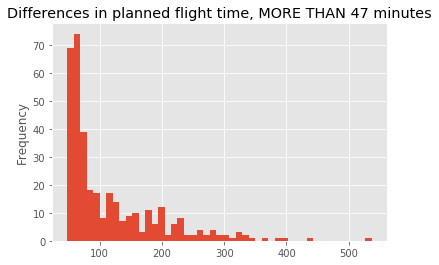

In [183]:
# We plot the 95th percentile of planned_dif (difference in duration of a flight for each distinct route of each airline) 
percent95 = int(query_df['planned_dif'].quantile(0.95))  # we need to cast it as integer, in order to feed it below

query_df[ (query_df['planned_dif'] < percent95) ]['planned_dif'].plot(kind='hist', bins=percent95)
plt.title('Differences in planned flight time, UP TO {} minutes'.format(percent95))
plt.show()


# we excluded a route that is way out of range, close to 1400 minutes...#
query_df[ (query_df['planned_dif'] > percent95) & (query_df['planned_dif'] < 1000) ]['planned_dif'].plot(kind='hist', bins=percent95)
plt.title('Differences in planned flight time, MORE THAN {} minutes'.format(percent95))
plt.show()


In [184]:
# It is obvious that when we include Diverted and Cancelled flights, variation in planned flight time is far greater.
# Something that shouldn't be...

In [185]:
# Let us take a closer look at two examples from the dataframe we open up this section

In [186]:
# This is one of the routes that shows up in a weird way. While CRSElapsedTime is usually 245, suddenly it drops to 42.

query = '''

select *
from flights
where UniqueCarrier == 'AA' and Origin == 'EGE' and Dest == 'MIA'
and Cancelled == 0 and Diverted == 0
order by CRSElapsedTime
limit 4
'''
	
my_queries(filepath_to_database, query)

,FlightYear,FlightMonth,FlightDay,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,5,6,2008-01-05 08:00,2008-01-05 10:45,2008-01-05 14:52,2008-01-05 13:27,AA,2398,N622AA,292,42,207,1525,1275,EGE,MIA,1811,14,71,0,None,0,1158.0,0.0,117.0,0.0,250.0
1,2008,1,12,6,2008-01-12 10:39,2008-01-12 10:45,2008-01-12 16:21,2008-01-12 16:50,AA,2398,N5EPAA,222,245,204,-29,-6,EGE,MIA,1811,4,14,0,None,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,13,7,2008-01-13 10:39,2008-01-13 10:45,2008-01-13 16:26,2008-01-13 16:50,AA,2398,N5CXAA,227,245,211,-24,-6,EGE,MIA,1811,5,11,0,None,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,19,6,2008-01-19 10:38,2008-01-19 10:45,2008-01-19 16:42,2008-01-19 16:50,AA,2398,N5DNAA,244,245,210,-8,-7,EGE,MIA,1811,23,11,0,None,0,NaN,NaN,NaN,NaN,NaN


In [187]:
# Note that the departure delay is 1275 minutes or 21h and 15m.
# The actual departure time is 800, which is exactly 21h and 15m after the planned departure - probably on the next day.
# The planned arrival time corresponds to the new departure time of 800, rather than the old of 1045
# That is, the planned arrival time is updated for the new actual departure, while the planned departure time is not.

In [188]:
# Fact39: In cases of long delays, some fields get updated for the new scheduled flight, while others do not.

In [189]:
# This is another case. While CRSElapsedTime is usually 121, suddenly it jumps to 290.

query = '''

select *
from flights
where UniqueCarrier == '9E' and Origin == 'PIT' and Dest == 'ATL' and FlightNum = 2029
and Cancelled == 0 and Diverted == 0
order by CRSElapsedTime desc
limit 4
'''
	
my_queries(filepath_to_database, query)

,FlightYear,FlightMonth,FlightDay,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,3,9,7,2008-03-09 18:23,2008-03-09 14:20,2008-03-09 20:51,2008-03-09 19:10,9E,2029,91469E,148,290,90,101,243,PIT,ATL,526,32,26,0,None,0,0.0,0.0,0.0,0.0,101.0
1,2008,5,1,4,2008-05-01 17:32,2008-05-01 17:20,2008-05-01 19:14,2008-05-01 19:21,9E,2029,91479E,102,121,77,-7,12,PIT,ATL,526,14,11,0,None,0,NaN,NaN,NaN,NaN,NaN
2,2008,5,2,5,2008-05-02 17:44,2008-05-02 17:20,2008-05-02 20:00,2008-05-02 19:21,9E,2029,91619E,136,121,77,39,24,PIT,ATL,526,14,45,0,None,0,0.0,0.0,15.0,0.0,24.0
3,2008,5,3,6,2008-05-03 18:04,2008-05-03 17:20,2008-05-03 19:47,2008-05-03 19:21,9E,2029,91479E,103,121,86,26,44,PIT,ATL,526,4,13,0,None,0,0.0,0.0,0.0,0.0,26.0


### Testing relations

In [190]:
# A list of relations that describe the data


# 1 ActualElapsedTime = TaxiOut + AirTime + TaxiIn 

# 2 ArrDelay = ArrTime - CRSArrTime

# 3 DepDelay = DepTime - CRSDepTime 

# 4 CRSActualElapsedTime = CRSArrTime - CRSDepTime 

# 5 ActualElapsedTime = ArrTime - DepTime

# 6 ArrDelay = CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay

# 7 derived from 2,3,4,5 (ArrDelay - DepDelay) == (ActualElapsedTime - CRSElapsedTime )


In [191]:
# Actual flight time always equals taxiing and air time

query = '''
select  ActualElapsedTime - TaxiOut - AirTime - TaxiIn as rel1
from flights
'''

my_queries(filepath_to_database, query).describe().astype(int)

,rel1
count,6855025
mean,0
std,0
min,0
25%,0
50%,0
75%,0
max,0


In [192]:
# Indeed delays are analysed in the five relevant categories

query = '''
select  - ArrDelay + CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay as rel2

from flights
'''

my_queries(filepath_to_database, query).describe().astype(int)

,rel2
count,1524733
mean,0
std,0
min,0
25%,0
50%,0
75%,0
max,0


In [193]:
# We test this relation with approximation of 1 minute. Indeed it holds for all not Diverted or Cancelled flights

query = '''
select count(*) as rel3
 
from flights
where Diverted == 0 and Cancelled == 0 and
abs(ArrDelay - DepDelay - ActualElapsedTime + CRSElapsedTime ) < 2

'''

my_queries(filepath_to_database, query)

,rel3
0,6855025
